# Task 3: Risk Management
The risk manager has collected data on the loan borrowers. The data is in tabular format, with each row providing details of the borrower, including their income, total loans outstanding, and a few other metrics. There is also a column indicating if the borrower has previously defaulted on a loan. You must use this data to build a model that, given details for any loan described above, will predict the probability that the borrower will default (also known as PD: the probability of default). Use the provided data to train a function that will estimate the probability of default for a borrower. Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan.

You should produce a function that can take in the properties of a loan and output the expected loss.
You can explore any technique ranging from a simple regression or a decision tree to something more advanced. You can also use multiple methods and provide a comparative analysis.

## Notebook
We are going to compare using a simple Machine Learning Algoritm (Decision Trees) against using a more complex Deep Learning Algorithm (MLP). This notebook will sample the models weights so that they can be imported and used in an expected loss function.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from task_3_util import display_df_summary, create_mlp, train_model, evaluate_mlp

random_state = 14


# Load the CSV data
df = pd.read_csv('Task 3 and 4_Loan_Data.csv')
display_df_summary(df)

Dataset Shape: (10000, 8)

First few rows:
   customer_id  credit_lines_outstanding  loan_amt_outstanding   
0      8153374                         0           5221.545193  \
1      7442532                         5           1958.928726   
2      2256073                         0           3363.009259   
3      4885975                         0           4766.648001   
4      4700614                         1           1345.827718   

   total_debt_outstanding       income  years_employed  fico_score  default  
0             3915.471226  78039.38546               5         605        0  
1             8228.752520  26648.43525               2         572        1  
2             2027.830850  65866.71246               4         602        0  
3             2501.730397  74356.88347               5         612        0  
4             1768.826187  23448.32631               6         631        0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Da

### Data Preparation

In [2]:
# Prepare features and target
# Remove customer_id as it's not a useful feature for prediction
features = df.drop(['customer_id', 'default'], axis=1)
target = df['default']

print("Features shape:", features.shape)
print("Target shape:", target.shape)
print("\nFeature columns:", features.columns.tolist())
print("\nTarget distribution:")
print(target.value_counts(normalize=True))

Features shape: (10000, 6)
Target shape: (10000,)

Feature columns: ['credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']

Target distribution:
default
0    0.8149
1    0.1851
Name: proportion, dtype: float64


### Data Splitting

In [3]:
# Split data into train, validation, and test sets
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    features, target, test_size=0.2, random_state=random_state, stratify=target
)

# Second split: 75% train, 25% validation (of the remaining 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=random_state, stratify=y_temp
)


print("Data split summary:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

print("\nTarget distribution in each set:")
print("Training:")
print(f"  Default (1): {y_train.value_counts()[1]} samples ({y_train.value_counts(normalize=True)[1]*100:.1f}%)")
print(f"  Non-default (0): {y_train.value_counts()[0]} samples ({y_train.value_counts(normalize=True)[0]*100:.1f}%)")

print("Validation:")
print(f"  Default (1): {y_val.value_counts()[1]} samples ({y_val.value_counts(normalize=True)[1]*100:.1f}%)")
print(f"  Non-default (0): {y_val.value_counts()[0]} samples ({y_val.value_counts(normalize=True)[0]*100:.1f}%)")

print("Test:")
print(f"  Default (1): {y_test.value_counts()[1]} samples ({y_test.value_counts(normalize=True)[1]*100:.1f}%)")
print(f"  Non-default (0): {y_test.value_counts()[0]} samples ({y_test.value_counts(normalize=True)[0]*100:.1f}%)")

Data split summary:
Training set: 6000 samples (60.0%)
Validation set: 2000 samples (20.0%)
Test set: 2000 samples (20.0%)

Target distribution in each set:
Training:
  Default (1): 1111 samples (18.5%)
  Non-default (0): 4889 samples (81.5%)
Validation:
  Default (1): 370 samples (18.5%)
  Non-default (0): 1630 samples (81.5%)
Test:
  Default (1): 370 samples (18.5%)
  Non-default (0): 1630 samples (81.5%)


## Decision Tree
### Training

=== Decision Tree Model - Training Set Performance ===
Training Accuracy: 0.9975

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4889
           1       0.99      0.99      0.99      1111

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000


Confusion Matrix:
[[4881    8]
 [   7 1104]]


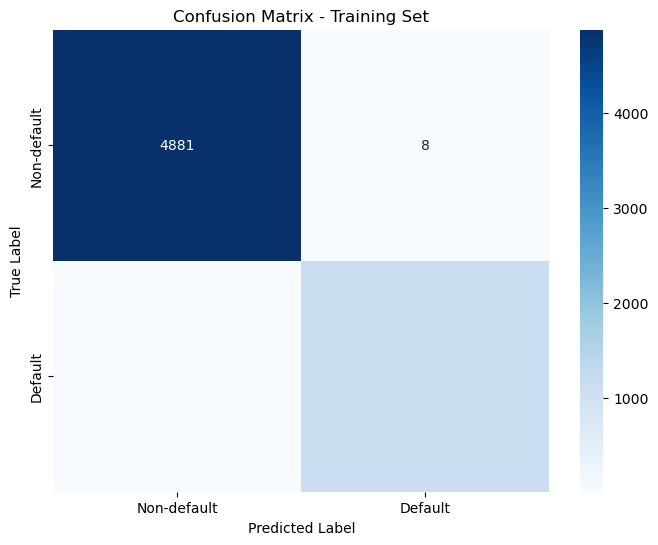


Feature Importance:
                    feature  importance
0  credit_lines_outstanding    0.897995
4            years_employed    0.081344
5                fico_score    0.014996
2    total_debt_outstanding    0.004622
3                    income    0.001042
1      loan_amt_outstanding    0.000000


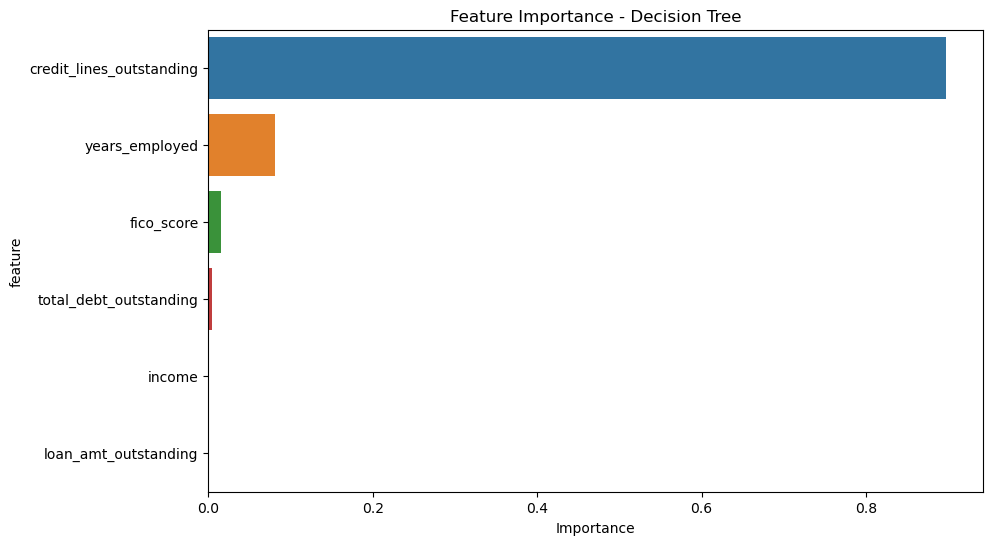

In [4]:
# Create and train the decision tree model
dt_model = DecisionTreeClassifier(random_state=random_state, max_depth=5)  # Limiting depth to prevent overfitting
dt_model.fit(X_train, y_train)

# Make predictions on training set
y_train_pred = dt_model.predict(X_train)
y_train_pred_proba = dt_model.predict_proba(X_train)[:, 1]  # Probability of default

# Evaluate on training set
print("=== Decision Tree Model - Training Set Performance ===")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

print("\nConfusion Matrix:")
cm_train = confusion_matrix(y_train, y_train_pred)
print(cm_train)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-default', 'Default'], 
            yticklabels=['Non-default', 'Default'])
plt.title('Confusion Matrix - Training Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance - Decision Tree')
plt.xlabel('Importance')
plt.show()

In [5]:
# Save model with metadata
model_data = {
    'model': dt_model,
    'feature_names': X_train.columns.tolist(),
    'training_accuracy': accuracy_score(y_train, y_train_pred),
    'model_type': 'DecisionTreeClassifier',
    'parameters': dt_model.get_params()
}

joblib.dump(model_data, 'decision_tree_model_with_metadata.joblib')

['decision_tree_model_with_metadata.joblib']

### Validation & Test Results

=== Decision Tree Model Performance Comparison ===

1. TRAINING SET:
Accuracy: 0.9975
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4889
           1       0.99      0.99      0.99      1111

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000


2. VALIDATION SET:
Accuracy: 0.9960
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1630
           1       0.99      0.99      0.99       370

    accuracy                           1.00      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000


3. TEST SET:
Accuracy: 0.9970
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1630
           1  

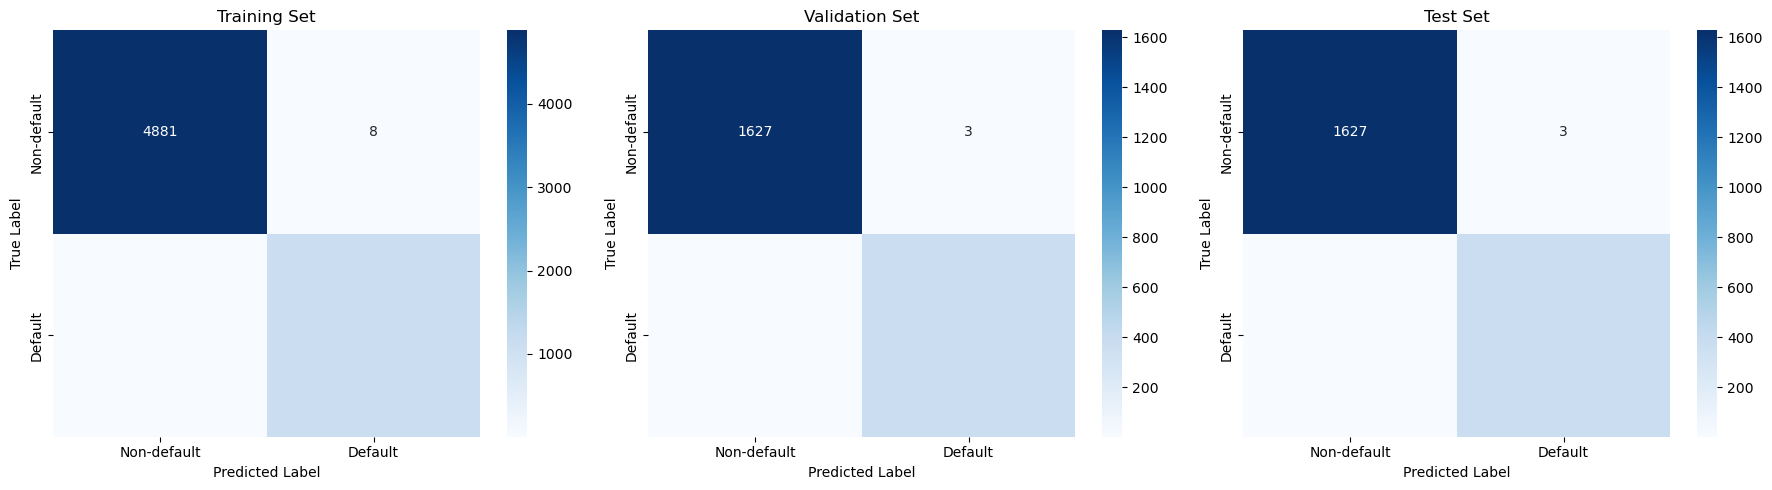


=== SUMMARY COMPARISON ===
Set          Accuracy   Precision  Recall     F1-Score  
-------------------------------------------------------
Training     0.9975     0.9928     0.9937     0.9933    
Validation   0.9960     0.9918     0.9865     0.9892    
Test         0.9970     0.9919     0.9919     0.9919    


In [6]:
# Make predictions on validation set
y_val_pred = dt_model.predict(X_val)
y_val_pred_proba = dt_model.predict_proba(X_val)[:, 1]

# Make predictions on test set
y_test_pred = dt_model.predict(X_test)
y_test_pred_proba = dt_model.predict_proba(X_test)[:, 1]

print("=== Decision Tree Model Performance Comparison ===")

# Training set results
print("\n1. TRAINING SET:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# Validation set results
print("\n2. VALIDATION SET:")
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Test set results
print("\n3. TEST SET:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrices for all sets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training set confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-default', 'Default'], 
            yticklabels=['Non-default', 'Default'])
axes[0].set_title('Training Set')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Validation set confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Non-default', 'Default'], 
            yticklabels=['Non-default', 'Default'])
axes[1].set_title('Validation Set')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

# Test set confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=['Non-default', 'Default'], 
            yticklabels=['Non-default', 'Default'])
axes[2].set_title('Test Set')
axes[2].set_ylabel('True Label')
axes[2].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Summary comparison
print("\n=== SUMMARY COMPARISON ===")
print(f"{'Set':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 55)

# Training metrics
dt_train_report = classification_report(y_train, y_train_pred, output_dict=True)
print(f"{'Training':<12} {accuracy_score(y_train, y_train_pred):<10.4f} {dt_train_report['1']['precision']:<10.4f} {dt_train_report['1']['recall']:<10.4f} {dt_train_report['1']['f1-score']:<10.4f}")

# Validation metrics
dt_val_report = classification_report(y_val, y_val_pred, output_dict=True)
print(f"{'Validation':<12} {accuracy_score(y_val, y_val_pred):<10.4f} {dt_val_report['1']['precision']:<10.4f} {dt_val_report['1']['recall']:<10.4f} {dt_val_report['1']['f1-score']:<10.4f}")

# Test metrics
dt_test_report = classification_report(y_test, y_test_pred, output_dict=True)
print(f"{'Test':<12} {accuracy_score(y_test, y_test_pred):<10.4f} {dt_test_report['1']['precision']:<10.4f} {dt_test_report['1']['recall']:<10.4f} {dt_test_report['1']['f1-score']:<10.4f}")

## Pytorch MLP Model

In [7]:
# Declare the Model
input_dim = X_train.shape[1]  # Number of features
hidden_dims = [64, 32]  # Two hidden layers with 64 and 32 units
output_dim = 1  # For binary classification

mlp_model = create_mlp(input_dim, hidden_dims, output_dim)
print(mlp_model)

Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)


Epoch 1/50 | Train Loss: 2612.2246 | Val Loss: 2203.9261 | Time: 0.11s
Epoch 2/50 | Train Loss: 1818.6849 | Val Loss: 1412.6708 | Time: 0.04s
Epoch 3/50 | Train Loss: 1025.0065 | Val Loss: 634.1833 | Time: 0.04s
Epoch 4/50 | Train Loss: 379.0759 | Val Loss: 195.2400 | Time: 0.04s
Epoch 5/50 | Train Loss: 177.4204 | Val Loss: 169.6251 | Time: 0.04s
Epoch 6/50 | Train Loss: 166.0098 | Val Loss: 159.9325 | Time: 0.04s
Epoch 7/50 | Train Loss: 155.9453 | Val Loss: 149.6653 | Time: 0.04s
Epoch 8/50 | Train Loss: 145.3089 | Val Loss: 138.7587 | Time: 0.04s
Epoch 9/50 | Train Loss: 133.9193 | Val Loss: 127.2694 | Time: 0.04s
Epoch 10/50 | Train Loss: 121.8635 | Val Loss: 114.8931 | Time: 0.04s
Epoch 11/50 | Train Loss: 109.0653 | Val Loss: 101.9978 | Time: 0.04s
Epoch 12/50 | Train Loss: 95.5360 | Val Loss: 87.9434 | Time: 0.04s
Epoch 13/50 | Train Loss: 81.1106 | Val Loss: 73.6278 | Time: 0.04s
Epoch 14/50 | Train Loss: 66.3167 | Val Loss: 58.8343 | Time: 0.04s
Epoch 15/50 | Train Loss: 51.4

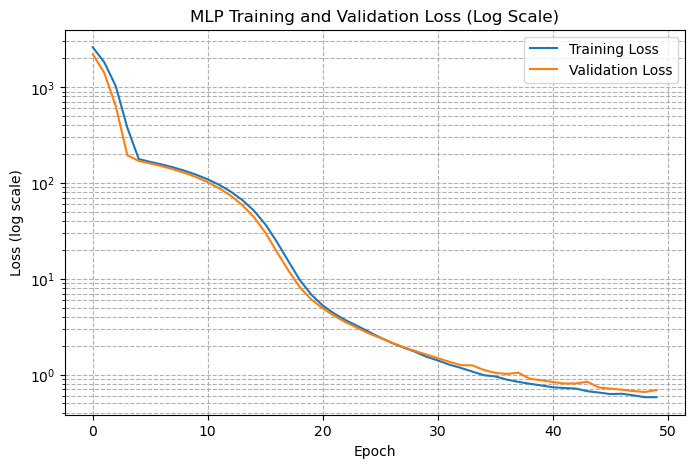

In [8]:
# Prepare the Data into Torch Dataset

# Prepare your data as torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Create model
input_dim = X_train.shape[1]
hidden_dims = [64, 32]
mlp_model = create_mlp(input_dim, hidden_dims, output_dim=1)

# Loss and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-5)

# Train
train_losses, val_losses, best_model_weights, trained_model = train_model(
    mlp_model, train_loader, val_loader, criterion, optimizer, epochs=50, device='cpu'
)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.title('MLP Training and Validation Loss (Log Scale)')
plt.yscale('log')  # Set y-axis to log scale
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [9]:
# Save the Best Model
torch.save(trained_model, 'mlp_model_entire.pth')

### Train Validation and Test Results

=== MLP Model Performance Comparison ===

1. TRAINING SET:
Accuracy: 0.9727
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      4889
         1.0       0.91      0.95      0.93      1111

    accuracy                           0.97      6000
   macro avg       0.95      0.96      0.96      6000
weighted avg       0.97      0.97      0.97      6000


2. VALIDATION SET:
Accuracy: 0.9710
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1630
         1.0       0.90      0.94      0.92       370

    accuracy                           0.97      2000
   macro avg       0.95      0.96      0.95      2000
weighted avg       0.97      0.97      0.97      2000


3. TEST SET:
Accuracy: 0.9715
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1630
         1.0       0.90 

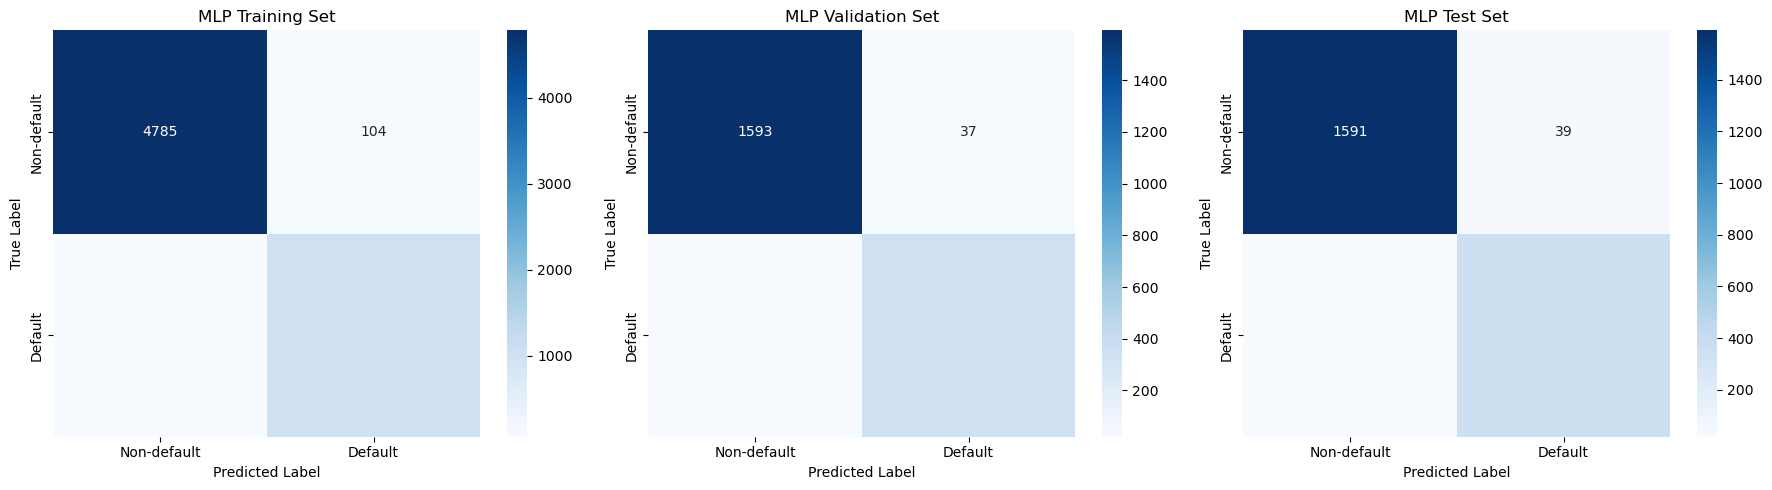


=== SUMMARY COMPARISON (MLP) ===
Set          Accuracy   Precision  Recall     F1-Score  
-------------------------------------------------------


AttributeError: 'str' object has no attribute 'keys'

In [ ]:
# Evaluate on train, val, and test sets
mlp_train_preds, mlp_train_targets = evaluate_mlp(trained_model, train_loader)
mlp_val_preds, mlp_val_targets = evaluate_mlp(trained_model, val_loader)
mlp_test_preds, mlp_test_targets = evaluate_mlp(trained_model, test_loader)  # You need to define test_loader

print("=== MLP Model Performance Comparison ===")

# Training set results
print("\n1. TRAINING SET:")
print(f"Accuracy: {accuracy_score(mlp_train_targets, mlp_train_preds):.4f}")
print("Classification Report:")
mlp_train_report = classification_report(mlp_train_targets, mlp_train_preds, output_dict=True)
print(mlp_train_report)

# Validation set results
print("\n2. VALIDATION SET:")
print(f"Accuracy: {accuracy_score(mlp_val_targets, mlp_val_preds):.4f}")
print("Classification Report:")
mlp_val_report = classification_report(mlp_val_targets, mlp_val_preds)
print(mlp_val_report)

# Test set results
print("\n3. TEST SET:")
print(f"Accuracy: {accuracy_score(mlp_test_targets, mlp_test_preds):.4f}")
print("Classification Report:")
mlp_test_report = classification_report(mlp_test_targets, mlp_test_preds)
print(mlp_test_report)

def print_type1_type2_errors(y_true, y_pred, set_name=""):
    cm = confusion_matrix(y_true, y_pred)
    # cm = [[TN, FP],
    #       [FN, TP]]
    TN, FP, FN, TP = cm.ravel()
    print(f"{set_name} Confusion Matrix:\n{cm}")
    print(f"{set_name} Type 1 Error (False Positive): {FP}")
    print(f"{set_name} Type 2 Error (False Negative): {FN}")

# Example usage for training set:
print_type1_type2_errors(mlp_train_targets, mlp_train_preds, set_name="Training")
print_type1_type2_errors(mlp_val_targets, mlp_val_preds, set_name="Validation")
print_type1_type2_errors(mlp_test_targets, mlp_test_preds, set_name="Test")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training set confusion matrix
cm_train = confusion_matrix(mlp_train_targets, mlp_train_preds)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-default', 'Default'], 
            yticklabels=['Non-default', 'Default'])
axes[0].set_title('MLP Training Set')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Validation set confusion matrix
cm_val = confusion_matrix(mlp_val_targets, mlp_val_preds)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Non-default', 'Default'], 
            yticklabels=['Non-default', 'Default'])
axes[1].set_title('MLP Validation Set')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

# Test set confusion matrix
cm_test = confusion_matrix(mlp_test_targets, mlp_test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[2],
            xticklabels=['Non-default', 'Default'], 
            yticklabels=['Non-default', 'Default'])
axes[2].set_title('MLP Test Set')
axes[2].set_ylabel('True Label')
axes[2].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

def get_type1_type2(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    return FP, FN

# Example for training set:
train_FP, train_FN = get_type1_type2(mlp_train_targets, mlp_train_preds)
val_FP, val_FN = get_type1_type2(mlp_val_targets, mlp_val_preds)
test_FP, test_FN = get_type1_type2(mlp_test_targets, mlp_test_preds)

# Summary comparison
print("\n=== SUMMARY COMPARISON (MLP) ===")
print(f"{'Set':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 55)


print(mlp_train_report.keys())
print(mlp_val_report.keys())
print(mlp_test_report.keys())

print(f"{'Set':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Type 1':<8} {'Type 2':<8}")
print("-" * 70)
print(f"{'Training':<12} {accuracy_score(mlp_train_targets, mlp_train_preds):<10.4f} "
      f"{mlp_train_report['1.0']['precision']:<10.4f} {mlp_train_report['1.0']['recall']:<10.4f} "
      f"{mlp_train_report['1.0']['f1-score']:<10.4f} {train_FP:<8} {train_FN:<8}")
print(f"{'Validation':<12} {accuracy_score(mlp_val_targets, mlp_val_preds):<10.4f} "
      f"{mlp_val_report['1']['precision']:<10.4f} {mlp_val_report['1']['recall']:<10.4f} "
      f"{mlp_val_report['1']['f1-score']:<10.4f} {val_FP:<8} {val_FN:<8}")
print(f"{'Test':<12} {accuracy_score(mlp_test_targets, mlp_test_preds):<10.4f} "
      f"{mlp_test_report['1']['precision']:<10.4f} {mlp_test_report['1']['recall']:<10.4f} "
      f"{mlp_test_report['1']['f1-score']:<10.4f} {test_FP:<8} {test_FN:<8}")

## Models Comparison

In [ ]:
# Decision Tree metrics (use '1' as key for int targets, '1.0' for float)
dt_positive_key = [k for k in dt_test_report.keys() if k in ['1', '1.0']][0]
mlp_positive_key = [k for k in mlp_test_report.keys() if k in ['1', '1.0']][0]